In [1]:
%load_ext autoreload
%autoreload 2
%aimport -fenics
%aimport -numpy 
%aimport -matplotlib
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import settings
import solution_io
import ice_physics



In [2]:

yr2sec = 365.25 * 24 * 60 * 60
experiment = settings.experiment(name="iso_lowres",resolution_l=20,resolution_w=8,resolution_h=3)
experiment = settings.experiment(name="iso",resolution_w=20)
#experiment = settings.experiment(name="exx0.1",icestream_Exx=0.1,resolution_w=20)



domain_w = experiment["domain_w"]
domain_h = experiment["domain_h"]
domain_l = experiment["domain_l"]
resolution_w = experiment["resolution_w"]
resolution_h = experiment["resolution_h"]
resolution_l = experiment["resolution_l"]
icestream_width = experiment["icestream_width"]
shearmargin_enhancement = experiment["shearmargin_enhancement"]
shearmargin_enhancement_pos = experiment["shearmargin_enhancement_pos"]
icestream_Exx = experiment["icestream_Exx"]
A = experiment["A"]
rho = experiment["rho"]
n = experiment["n"]
gmag = experiment["gmag"]
alpha = experiment["alpha"]
beta2 = experiment["weertman_beta2"]


In [3]:
if experiment["model_half"]:
    mesh = BoxMesh(Point(0, 0, 0), Point(domain_l, +domain_w / 2, domain_h), resolution_l, resolution_w, resolution_h)
else:
    mesh = BoxMesh(Point(0, -domain_w / 2, 0), Point(domain_l, +domain_w / 2, domain_h), resolution_l, resolution_w, resolution_h)

# mesh refinement.
for x in mesh.coordinates():
    x[2] = (x[2] / domain_h) ** 1.7 * domain_h
    amp = icestream_width / 10
    if abs(x[1]) < (icestream_width * 0.75):
        x[1] += np.sin((x[1] / icestream_width - 1) * 2 * np.pi) * amp
    else:
        x[1] += np.sign(x[1]) * (abs(x[1]) - domain_w / 2) / ((domain_w / 2 - icestream_width * 0.75)) * amp


In [4]:

Uele = VectorElement("CG", mesh.ufl_cell(), 2)
Pele = FiniteElement("CG", mesh.ufl_cell(), 1)

MixedEle = MixedElement([Uele, Pele])

U = VectorFunctionSpace(mesh, "CG", 2)
P = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, MixedEle)

(u, p) = TrialFunctions(W)  # the unknowns
(v, q) = TestFunctions(W)  # the weighting funcs
w = Function(W)


e_x = Expression(("1.0", "0.0", "0.0"), element=Uele)
e_y = Expression(("0.0", "1.0", "0.0"), element=Uele)
e_z = Expression(("0.0", "0.0", "1.0"), element=Uele)


In [5]:
#BCs
near = lambda a, b: abs(a - b) < 0.1
bottom_noslip = lambda x, on_boundary: on_boundary and near(x[2], 0) and (abs(x[1]) >= icestream_width / 2)
bottom = lambda x, on_boundary: on_boundary and near(x[2], 0)
side = lambda x, on_boundary: on_boundary and near(abs(x[1]), domain_w / 2)
icedivide = lambda x, on_boundary: on_boundary and near(abs(x[0]), 0)
front = lambda x, on_boundary: on_boundary and near(x[0], domain_l)
top = lambda x, on_boundary: on_boundary and near(x[2], domain_h)
centerline = lambda x, on_boundary: on_boundary and near(x[1], 0)

class bottom_weertman(SubDomain):
    def inside(self, x, on_boundary):
        return bottom(x, on_boundary) and not bottom_noslip(x, on_boundary)

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
bottom_weertman().mark(boundaries, 1)
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)



bc = [DirichletBC(W.sub(1), Constant(0), top)]
bc += [DirichletBC(W.sub(0).sub(0), Constant(0), bottom_noslip)]
bc += [DirichletBC(W.sub(0).sub(1), Constant(0), bottom_noslip)]
bc += [DirichletBC(W.sub(0).sub(2), Constant(0), bottom)]
bc += [DirichletBC(W.sub(0).sub(1), Constant(0), side)]
bc += [DirichletBC(W.sub(0).sub(0), Constant(0), icedivide)]
if experiment["model_half"]:
    bc += [DirichletBC(W.sub(0).sub(1), Constant(0), centerline)]

# https://bitbucket.org/fenics-project/dolfin/issues/252/function-assignment-failing-with-mixed
#hydrostatic_pressure = Expression("dpdz*(H-x[2])", H=domain_h, dpdz=rho * gmag / np.cos(alpha), degree=1)
#p0 = interpolate(hydrostatic_pressure, P)
#assign(w.sub(1), p0)
#init_name=None
#if experiment['name']=='iso':
#    init_name = "iso_lowres"
#if init_name:
#    print(f'initializing with {init_name} DISABLED!')
#    fname_initialize = settings.filename3d(settings.experiment(name=init_name))
#    result_init = solution_io.load_solution(fname_initialize)
#    v0 = interpolate(result_init['u'], U)
#    assign(w.sub(0), v0)


initializing with iso_lowres DISABLED!


In [6]:


#q_degree = 7
#DX = dx(metadata={'quadrature_degree': q_degree})
DX = dx

def a_fun(n):
    if n == 1:
        AA = A * 2.2e10  
    else:
        AA = A  
    eps = ice_physics.strainrate(u)
    if icestream_Exx==1:
        tau = ice_physics.tau(eps, AA , n)
    else:
        Exx = Expression("1+(Exx-1)/(1+exp(-((iw -abs(x[1])))/1e3))",
            iw=icestream_width,Exx=icestream_Exx, degree=1)
        tau = ice_physics.tau_orthotropic(eps, AA, n, Exx, 1, 1, 1, 1, 1)
    
    a = (inner(sym(grad(v)), tau) - div(v) * p + q * div(u)) * DX
    a += beta2 * dot(v, u) * ds(1)
    return a



g = Constant((sin(alpha) * gmag * rho, 0, -cos(alpha) * gmag * rho))  # grav vec
L = inner(v, g) * DX




In [7]:
print("\nRunning 3d experiment: ", experiment["name"])
settings.print_experiment_highlights(experiment)
list_linear_solver_methods()
list_krylov_solver_preconditioners()

solver_parameters = {"linear_solver": "mumps", "preconditioner": "petsc_amg"}
#solver_parameters = {"linear_solver": "tfqmr", "preconditioner": "hypre_amg"}
solve(a_fun(n=1) == L, w, bc, solver_parameters=solver_parameters)
(usol, psol) = w.split(deepcopy=True)
print('solved')


Running 3d experiment:  iso
{'name': 'iso', 'resolution_w': 20}
Solver method  |  Description                                                 
------------------------------------------------------------------------------
bicgstab       |  Biconjugate gradient stabilized method                      
cg             |  Conjugate gradient method                                   
default        |  default linear solver                                       
gmres          |  Generalized minimal residual method                         
minres         |  Minimal residual method                                     
mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
petsc          |  PETSc built in LU solver                                    
richardson     |  Richardson method                                           
superlu        |  SuperLU                                                     
superlu_dist   |  Parallel SuperLU                                

In [ ]:
if n != 1:  # NLIN
    print("NON-LINEAR SOLVE!")
    F = a_fun(n) - L
    R = action(F, w)
    DR = derivative(R, w)  # Gateaux derivative
    problem = NonlinearVariationalProblem(R, w, bc, DR)
    solver = NonlinearVariationalSolver(problem)
    prm = solver.parameters
    prm["newton_solver"]["linear_solver"] = "umfpack"  # ?
    prm["newton_solver"]["relative_tolerance"] = 1e-4
    prm["newton_solver"]["absolute_tolerance"] = 1e-3
    prm["newton_solver"]["relaxation_parameter"] = 0.41
    prm["newton_solver"]["maximum_iterations"] = 30  # 100?
    prm["newton_solver"]["convergence_criterion"] = "incremental"
    # -------------------
    prm["newton_solver"]["report"] = True
    prm["newton_solver"]["error_on_nonconvergence"] = False
    prm["newton_solver"]["krylov_solver"]["report"] = True
    prm["newton_solver"]["krylov_solver"]["monitor_convergence"] = True
    prm["newton_solver"]["krylov_solver"]["nonzero_initial_guess"] = True
    prm["newton_solver"]["krylov_solver"]["error_on_nonconvergence"] = False

    solver.solve()
else:
    print(f"n=1 - so skipping non-linear solver.")

(usol, psol) = w.split(deepcopy=True)


fname = settings.filename3d(experiment)
print("saving to ", fname)
solution_io.save_solution(fname, mesh, usol, psol, experiment)

Text(0.5, 1.0, 'Vmag m/yr')

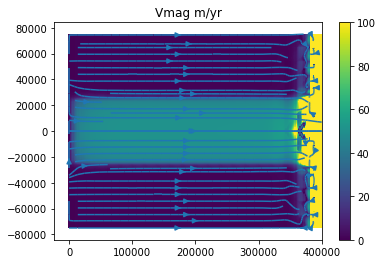

In [ ]:
x = np.linspace(0, domain_l, 200)
y = np.linspace(-domain_w / 2, domain_w / 2, 200)
[X, Y] = np.meshgrid(x, y)
Vx = np.empty(X.shape)
Vy = np.empty(X.shape)
Pmap = np.empty(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        v = usol(X[r, c], np.abs(Y[r, c]), domain_h)
        Vx[r, c] = v[0]
        Vy[r, c] = v[1] * np.sign(Y[r, c])
        Pmap[r, c] = psol(X[r, c], np.abs(Y[r, c]), 0)
V = np.sqrt(Vx ** 2 + Vy ** 2)
plt.pcolormesh(X, Y, V * yr2sec,vmax=100)
plt.colorbar()
plt.streamplot(X, Y, Vx, Vy)
np.max(V * yr2sec)
plt.title("Vmag m/yr")

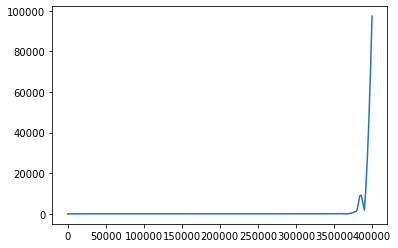

In [ ]:
plt.plot(x,V[int(len(y)/2),:] * yr2sec)